# Predict female behav vars from surrogate single-neuron activity

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from disp import set_plot
from my_torch import skl_fit_lin_single

cc = np.concatenate

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

PTRAIN = .8
NSPLIT = 30

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

NRL_MDLS = [
    'lin',  # linear neural model
    'lin2e',  # linear neural model (two-exp fit)
    'linr',  # linear neural model (fit w ridge regr)
    'ln',  # linear-nonlinear model
    'ln2e',  # linear-nonlinear model (two-exp fit)
    'lnr',  # linear-nonlinear model (fit w ridge regr)
    'ma',  # mult-adapt neural model
    'masoff',  # mult-adapt neural model with sine offset responses
]

In [2]:
PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = len(ISTRAIN)
NTRAIN = int(round(PTRAIN*NTR))

In [ ]:
for nrl_mdl in NRL_MDLS:
    pfx_nrl = f'data/simple/mlv/neur_basic/baker_{nrl_mdl}/mlv_baker_{nrl_mdl}'
    
    df_baker_fit_param = pd.read_csv(f'data/simple/neur/baker_{nrl_mdl}_fit_param.csv')
    r_cols_use = [f'R_{ir}' for ir in df_baker_fit_param.EXPT_ID]
    
    fsave = f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_single_{STRAIN_KEY}_{TARG_BHV.lower()}.npy'
    
    # fit model
    rslt = skl_fit_lin_single(
        pfxs=[pfx_nrl, PFX_BHV],
        cols_x=r_cols_use,
        targs=TARGS,
        itr_all=ISTRAIN,
        ntrain=NTRAIN,
        nsplit=NSPLIT)
    
    # save results
    save_data = {
        'r2_train': rslt.r2_train,
        'r2_test': rslt.r2_test,
        
        'w': rslt.w,
        'bias': rslt.bias,
        
        'targs': TARGS,
        
        'ntr': NTR,
        'ntrain': NTRAIN,
        'nsplit': NSPLIT
    }
    
    np.save(fsave, np.array([save_data]))

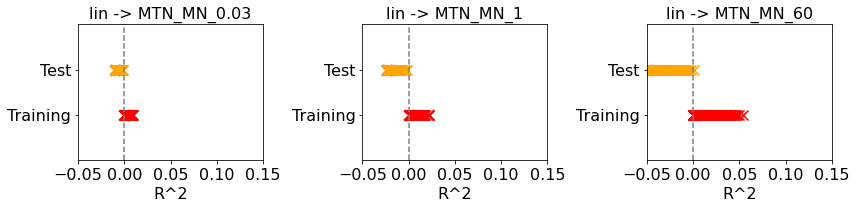

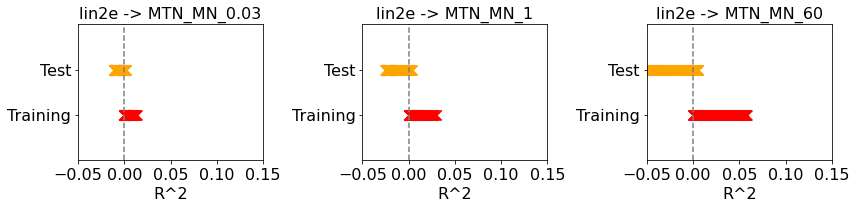

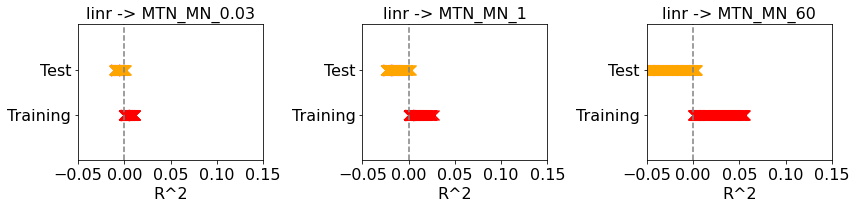

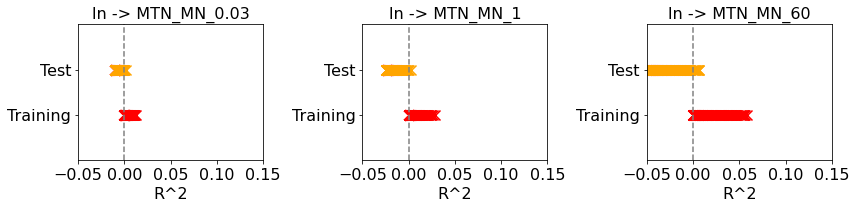

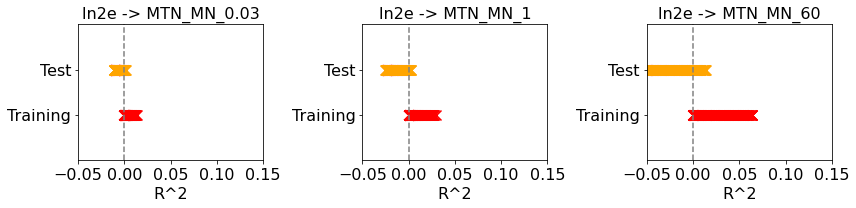

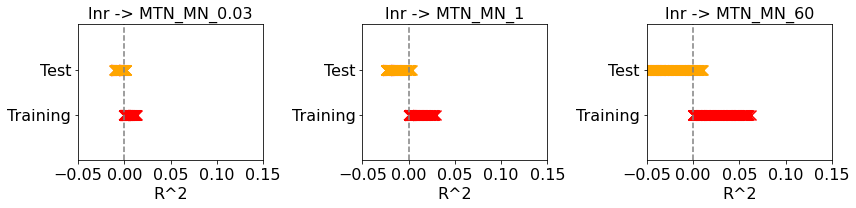

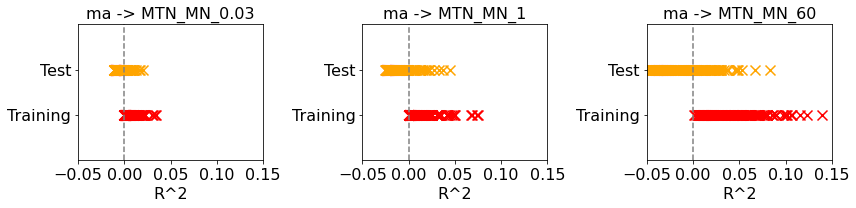

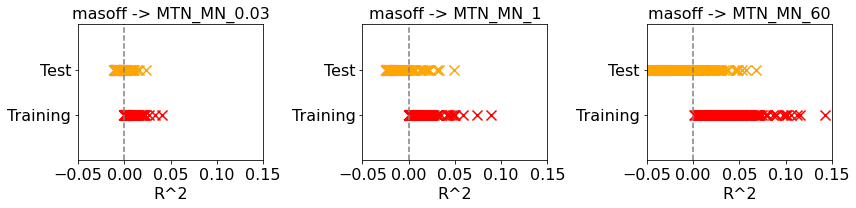

In [5]:
for nrl_mdl in NRL_MDLS:
    fsave = f'data/simple/mlv/neur_basic/baker_{nrl_mdl}_single_{STRAIN_KEY}_{TARG_BHV.lower()}.npy'

    data = np.load(fsave, allow_pickle=True)[0]
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)
    
    for ax, targ, in zip(axs, TARGS):
        
        r2_train = data['r2_train'][targ].mean(axis=0)  # avg over splits
        r2_test = data['r2_test'][targ].mean(axis=0)  
        
        ax.scatter(r2_train, np.zeros(len(r2_train)), c='r', marker='x', s=100)
        ax.scatter(r2_test, np.ones(len(r2_test)), c='orange', marker='x', s=100)
        
        ax.axvline(0, color='gray', ls='--')
        
        set_plot(ax, x_lim=(-.05, .15), y_lim=(-1, 2), y_ticks=[0, 1], y_tick_labels=['Training', 'Test'], x_label='R^2', title=f'{nrl_mdl} -> {targ}', font_size=16)